In [1]:
# !pip install imutils

In [2]:
# !pip uninstall opencv-python

In [3]:
# !pip install opencv-contrib-python==3.4.2.17

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

### Pipeline Steps:

    1. Keypoint detection
    2. Local invariant descriptors (SIFT, SURF, etc)
    3. Feature matching
    4. Homography estimation using RANSAC
    5. Perspective warping

In [5]:
# select the image id (valid values 1,2,3 or 4)

feature_extractor= 'orb'
feature_matching= 'bf'

In [6]:
# load the actual image and the wrapper image

act_img= cv2.imread(r"C:\Users\varsha\Pictures\CV_IMG\Panorama_img\foto1A.jpg")
wrapper_img= cv2.imread(r"C:\Users\varsha\Pictures\CV_IMG\Panorama_img\foto1B.jpg")

Text(0.5, 1.0, 'Wrapper Image')

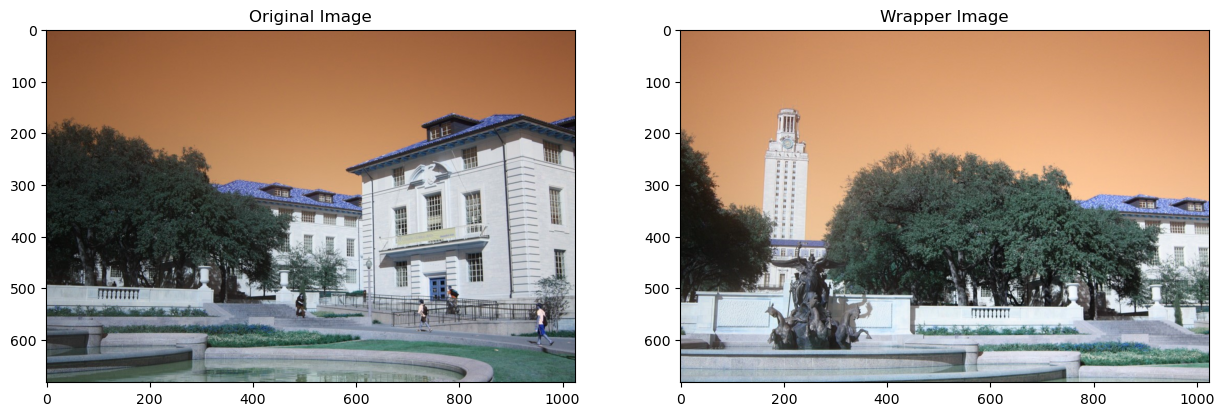

In [7]:
# plot the image
fig, axs= plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(act_img)
axs[0].set_title('Original Image')
axs[1].imshow(wrapper_img)
axs[1].set_title('Wrapper Image')

Text(0.5, 1.0, 'RGB Wrapper Image')

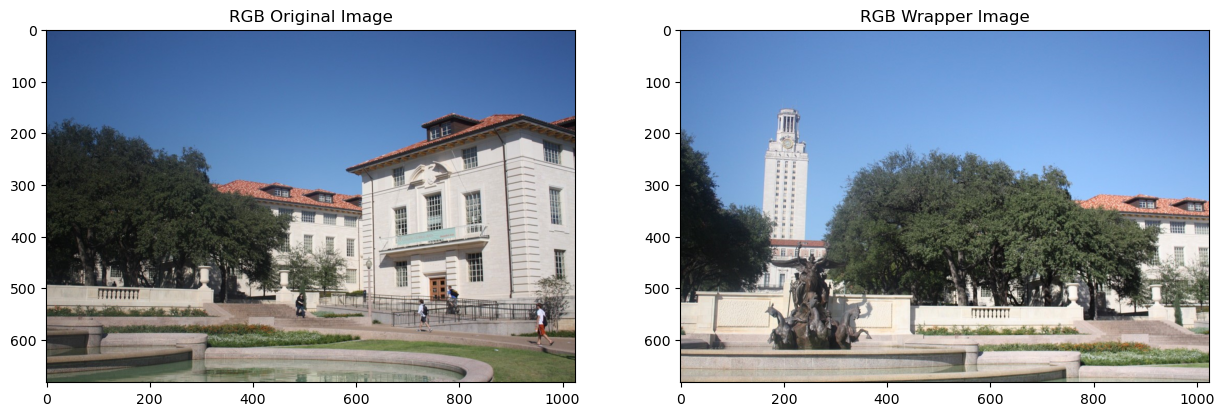

In [8]:
# convert BGR to RGB scale
rgb_act_img= cv2.cvtColor(act_img, cv2.COLOR_BGR2RGB)
rgb_wrap_img= cv2.cvtColor(wrapper_img, cv2.COLOR_BGR2RGB)

# plot the image
fig, axs= plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(rgb_act_img)
axs[0].set_title('RGB Original Image')
axs[1].imshow(rgb_wrap_img)
axs[1].set_title('RGB Wrapper Image')

Text(0.5, 1.0, 'RGB Wrapper Image')

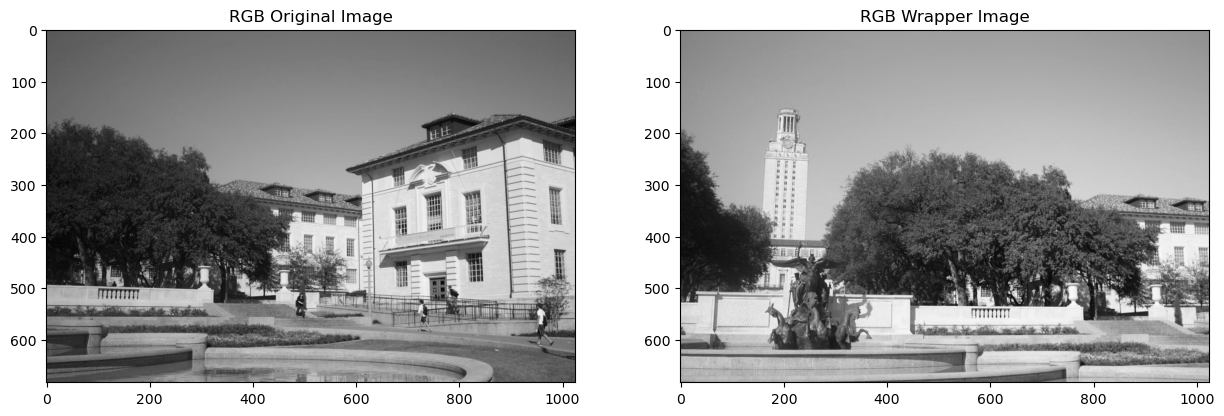

In [9]:
# Convert RGB to gray scale

gray_act_img= cv2.cvtColor(act_img, cv2.COLOR_RGB2GRAY)
gray_wrap_img= cv2.cvtColor(wrapper_img, cv2.COLOR_RGB2GRAY)

# plot the image
fig, axs= plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(gray_act_img, cmap= 'gray')
axs[0].set_title('RGB Original Image')
axs[1].imshow(gray_wrap_img, cmap= 'gray')
axs[1].set_title('RGB Wrapper Image')

### Keypoints and Descriptors.

Methods like SIFT and SURF try to address the limitations of corner detection algorithms. Usually, corner detector algorithms use a fixed size kernel to detect regions of interest (corners) on images. It is easy to see that when we scale an image, this kernel might become too small or too big.

To address this limitation, methods like SIFT uses Difference of Gaussians (DoD). The idea is to apply DoD on differently scaled versions of the same image. It also uses the neighboring pixel information to find and refine key points and corresponding descriptors.

In [10]:
# function to detect key points and features descriptions

def detectAndDescribe(img, method= None):
    
    assert method is not None     # define a feature detection method, it can be 'sift' or 'surf'
    
    # detect and extract feature from the image
    if method== 'sift':
        descriptor= cv2.SIFT_create()
    elif method== 'surf':
        descriptor= cv2.xfeatures2d.SURF_create()
    elif method== 'brisk':
        descriptor= cv2.BRISK_create()
    elif method== 'orb':
        descriptor= cv2.ORB_create()
        
    #get keypoint and descriptor
    (kps, descriptor)= descriptor.detectAndCompute(img, None)
    
    return kps,descriptor


In [11]:
# Find Keypoints and descriptors for actual and wrapper img
(kpsA, descriptorA)= detectAndDescribe(gray_act_img, feature_extractor)
(kpsB, descriptorB)= detectAndDescribe(gray_wrap_img, feature_extractor)

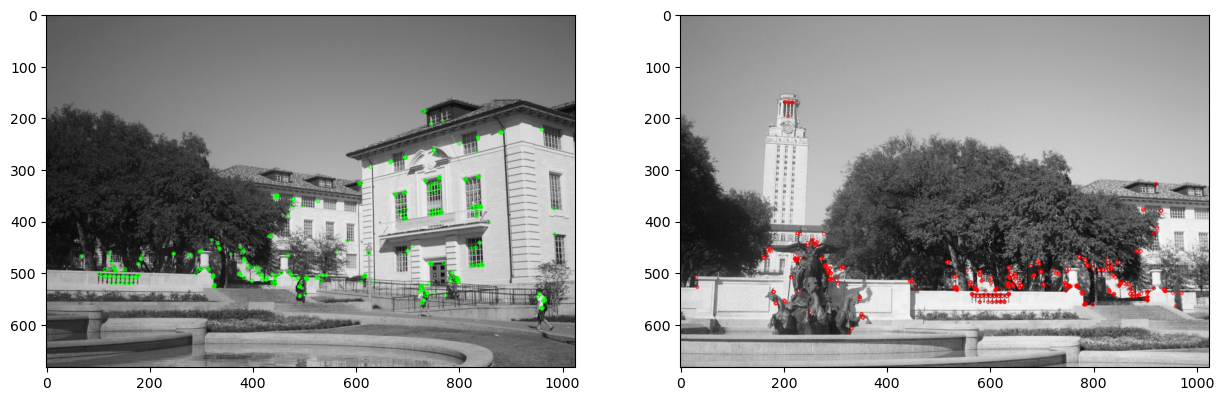

In [12]:
# plot key points on the image
fig, axs= plt.subplots(1, 2, figsize=(15,15), constrained_layout= False)
axs[0].imshow(cv2.drawKeypoints(gray_act_img, kpsA, None, color=(0,255,0)))
axs[1].imshow(cv2.drawKeypoints(gray_wrap_img, kpsB, None, color=(255,0,0)))

### Feature Matching

As we can see, we have a large number of features from both images. Now, we would like to compare the 2 sets of features and stick with the pairs that show more similarity.

With OpenCV, feature matching requires a Matcher object. Here, we explore two flavors:

    Brute Force Matcher
    KNN (k-Nearest Neighbors)

#### Note: For SIFT and SURF OpenCV recommends using Euclidean distance. For other feature extractors like ORB and BRISK, Hamming distance is suggested.

In [13]:
def createMatcher(method, crossCheck):

    # Recommended to use Euclidian dist for SIFT and SURF methods
    if method=='sift' or method=='surf':
        bf= cv2.BFMatcher_create(cv2.NORM_L2, crossCheck= crossCheck) 
    
    #Recommended to use Hamming Dist for ORB and BRISK methods
    elif method=='orb' or method=='brisk':
        bf= cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck= crossCheck)
        
    return bf

The crossCheck bool parameter indicates whether the two features have to match each other to be considered valid. In other words, for a pair of features (f1, f2) to considered valid, f1 needs to match f2 and f2 has to match f1 as the closest match as well. This procedure ensures a more robust set of matching features and is described in the original SIFT paper.

### BruteForce (BF) Matcher
The BruteForce (BF) Matcher does exactly what its name suggests. Given 2 sets of features (from image A and image B), each feature from set A is compared against all features from set B. 

By default, BF Matcher computes the Euclidean distance between two points. Thus, for every feature in set A, it returns the closest feature from set B.

In [14]:
def matchKeyPointsBF(featureA, featureB, mehtod):
    bf= createMatcher(mehtod, crossCheck=True)
    
    #Match descriptor
    best_matches= bf.match(featureA, featureB)
    
    #Sort the features with respect to the distance the points with small distance(more similarity) are ordered first in the vector
    rawMatches= sorted(best_matches, key= lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    
    return rawMatches
    

### KNN (k-Nearest Neighbors)

For cases where we want to consider more than one candidate match, we can use a KNN based matching procedure.

Instead of returning the single best match for a given feature, KNN returns the k best matches.

Note that the value of k has to be pre-defined by the user. As we expect, KNN provides a larger set of candidate features. However, we need to ensure that all these matching pairs are robust before going further.

In [15]:
def matchKeyPointsKNN(feaureA, featureB, ratio, method):
    bf= createMatcher(method, crossCheck=False)
    
    # compute the raw matches and initialize the list of the actual matches
    rawMatches= bf.knnMatch(featureA, featureB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches=[]
    
    #loop over rawMatches
    for m, n in rawMatches:
        
        # ensure the distance is within a certain ratio of eachother (i.e. Lowe's ratio test)
        if m.distance< n.distance * ratio:
            matches.append(m)
            
    return matches

#### Ratio Testing

To make sure the features returned by KNN are well comparable, the authors of the SIFT paper, suggests a technique called ratio test. Basically, we iterate over each of the pairs returned by KNN and perform a distance test. For each pair of features (f1, f2), if the distance between f1 and f2 is within a certain ratio, we keep it, otherwise, we throw it away. Also, the ratio value must be chosen manually.

Using: bf feature matcher
Raw matches (Brute force): 186


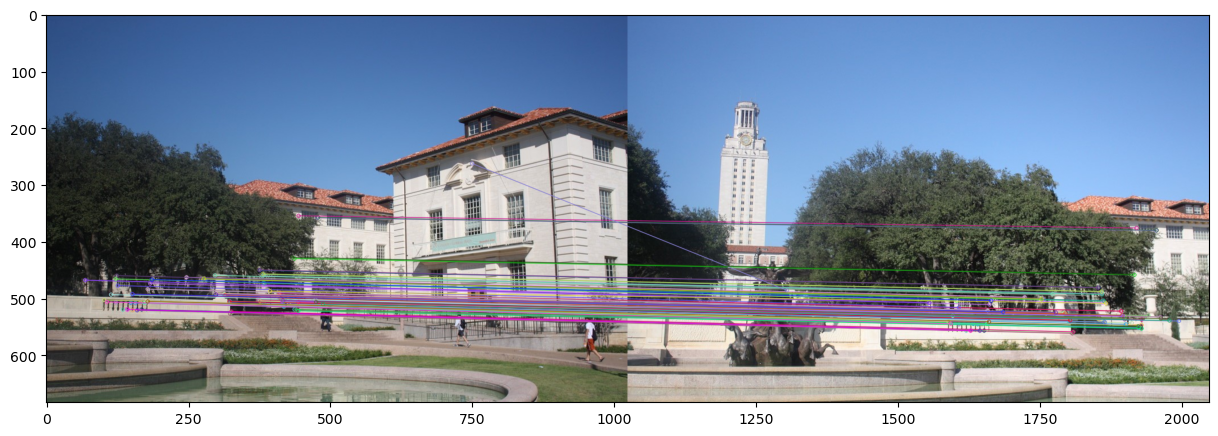

In [16]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(15,15))

if feature_matching=='bf':
    matches= matchKeyPointsBF(descriptorA, descriptorB, mehtod=feature_extractor)
    img3= cv2.drawMatches(rgb_act_img, kpsA, rgb_wrap_img, kpsB, matches[:100], None, flags= cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    
elif feature_matching=='knn':
    matches= matchKeyPointsKNN(descriptorA, descriptorB, ratio=0.75, method= feature_extractor)
    img3= cv2.drawMatches(rgb_act_img, kpsA, rgb_wrap_img, kpsB, np.random.choice(matches,100), None, flags= cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    
plt.imshow(img3)

### Homography (Stiching)

Now, we need to take these points and find the transformation matrix that will stitch the 2 images together based on their matching points.

Such a transformation is called the Homography matrix. Briefly, the homography is a 3x3 matrix that can be used in many applications such as camera pose estimation, perspective correction, and image stitching. 

The Homography is a 2D transformation. It maps points from one plane (image) to another. 

### Estimating the Homography

RANdom SAmple Consensus or RANSAC is an iterative algorithm to fit linear models. Different from other linear regressors, RANSAC is designed to be robust to outliers.

Models like Linear Regression uses least-squares estimation to fit the best model to the data. However, ordinary least squares is very sensitive to outliers. As a result, it might fail if the number of outliers is significant.

RANSAC solves this problem by estimating parameters only using a subset of inliers in the data.

In [73]:
# Homography

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    
    #convert the keypoints to numpy array
    kpsA= np.float32([kp.pt for kp in kpsA])
    kpsB= np.float32([kp.pt for kp in kpsB])
        
    if len(matches)>4:
        
        # construct two set of points
        ptsA= np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB= np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate homography between the two sets of point
        (H, status)= cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
        
        return (matches, H, status)
    else:
        return None

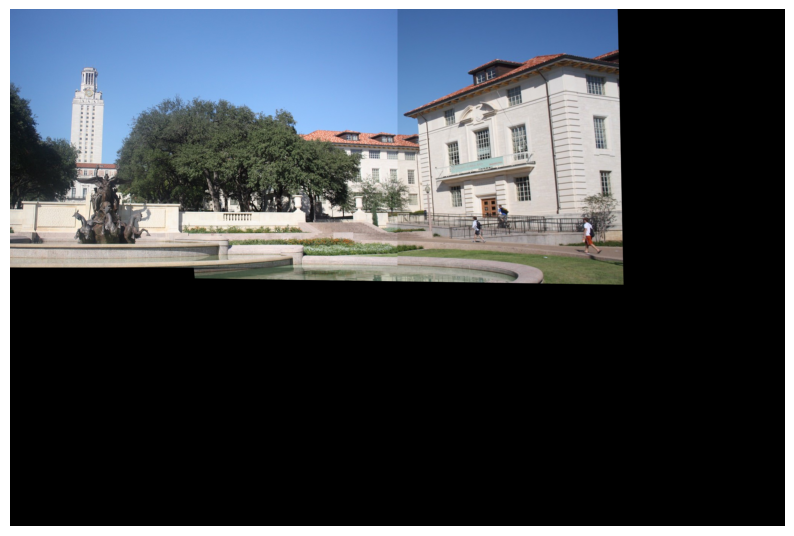

In [74]:
M= getHomography(kpsA, kpsB, descriptorA, descriptorB, matches, reprojThresh=4)

if M is None:
    print('Error!')
    
(matches, H, status)= M

# Apply panorama correction
width= rgb_act_img.shape[1] + rgb_wrap_img.shape[1]
height= rgb_act_img.shape[0] + rgb_wrap_img.shape[0]

result= cv2.warpPerspective(rgb_act_img, H, (width, height))
result[0:rgb_wrap_img.shape[0], 0:rgb_wrap_img.shape[1]] = rgb_wrap_img

plt.figure(figsize=(10,10))
plt.imshow(result)

plt.axis('off')
plt.show()

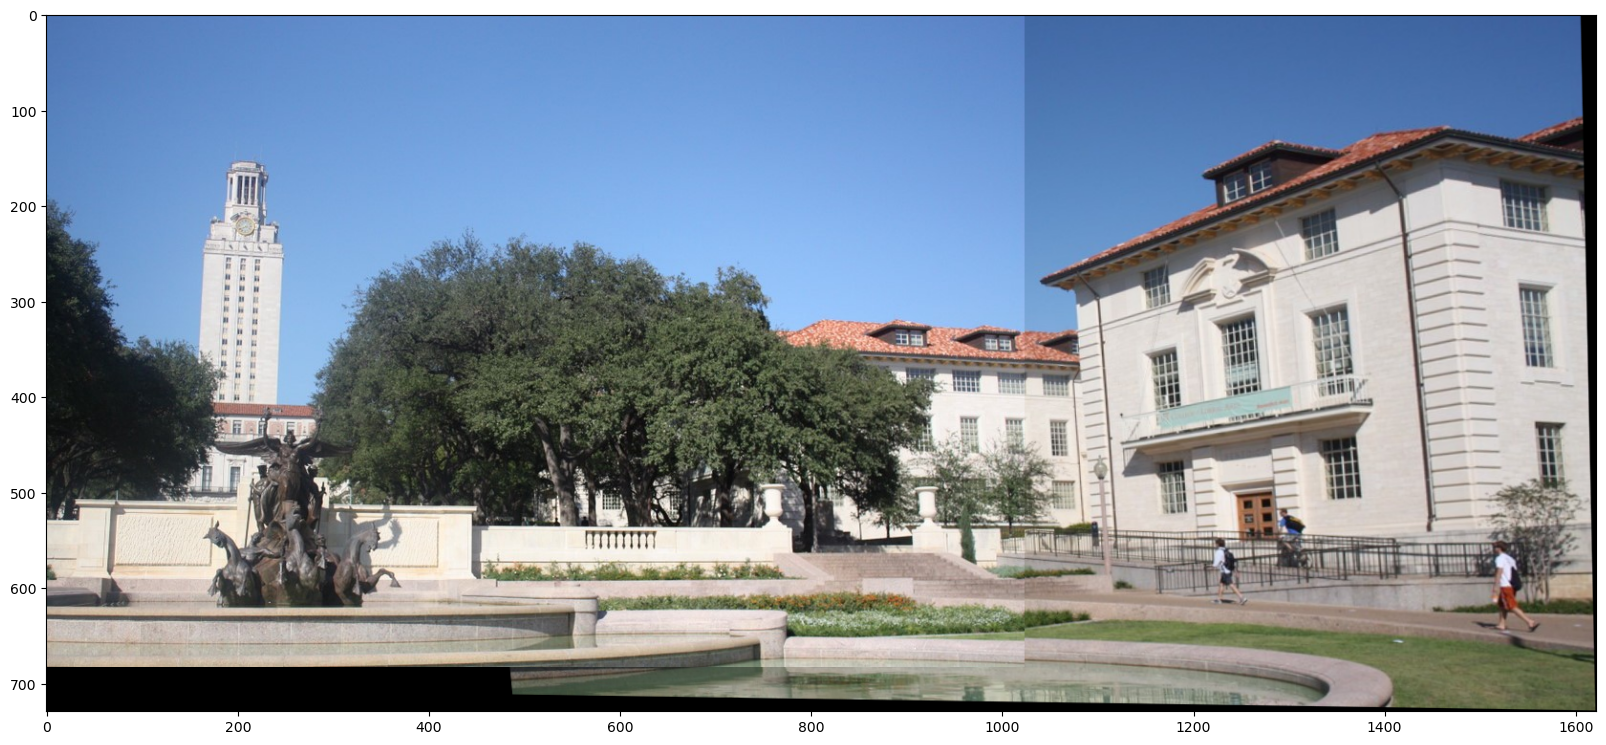

In [77]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

## Tkinter

In [20]:
import tkinter as tk
from tkinter import filedialog

In [78]:
def create_img(img_path1, img_path2):
    
    # select the image id (valid values 1,2,3 or 4)
    feature_extractor= 'orb'
    feature_matching= 'bf'

    # load the actual image and the wrapper image
    act_img= cv2.imread(img_path1)
    wrapper_img= cv2.imread(img_path2)

    # convert BGR to RGB scale
    rgb_act_img= cv2.cvtColor(act_img, cv2.COLOR_BGR2RGB)
    rgb_wrap_img= cv2.cvtColor(wrapper_img, cv2.COLOR_BGR2RGB)

    # Convert RGB to gray scale

    gray_act_img= cv2.cvtColor(act_img, cv2.COLOR_RGB2GRAY)
    gray_wrap_img= cv2.cvtColor(wrapper_img, cv2.COLOR_RGB2GRAY)

    # Find Keypoints and descriptors for actual and wrapper img
    (kpsA, descriptorA)= detectAndDescribe(gray_act_img, feature_extractor)
    (kpsB, descriptorB)= detectAndDescribe(gray_wrap_img, feature_extractor)

    print("Using: {} feature matcher".format(feature_matching))

    if feature_matching=='bf':
        matches= matchKeyPointsBF(descriptorA, descriptorB, mehtod=feature_extractor)
        img3= cv2.drawMatches(rgb_act_img, kpsA, rgb_wrap_img, kpsB, matches[:100], None, flags= cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    elif feature_matching=='knn':
        matches= matchKeyPointsKNN(descriptorA, descriptorB, ratio=0.75, method= feature_extractor)
        img3= cv2.drawMatches(rgb_act_img, kpsA, rgb_wrap_img, kpsB, np.random.choice(matches,100), None, flags= cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    M= getHomography(kpsA, kpsB, descriptorA, descriptorB, matches, reprojThresh=4)

    if M is None:
        print('Error!')

    (matches, H, status)= M

    # Apply panorama correction
    width= rgb_act_img.shape[1] + rgb_wrap_img.shape[1]
    height= rgb_act_img.shape[0] + rgb_wrap_img.shape[0]
    
    result= cv2.warpPerspective(rgb_act_img, H, (width, height))
    result[0:rgb_wrap_img.shape[0], 0:rgb_wrap_img.shape[1]] = rgb_wrap_img
    
    # transform the panorama image to grayscale and threshold it 
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    # Finds contours from the binary image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # get the maximum contour area
    c = max(cnts, key=cv2.contourArea)

    # get a bbox from the contour area
    (x, y, w, h) = cv2.boundingRect(c)

    # crop the image to the bbox coordinates
    result = result[y:y + h, x:x + w]
    
    result= cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result


In [79]:
def select_img():
    
    filepath1, filepath2= filedialog.askopenfilenames()
    
    img= create_img(filepath1, filepath2)
    print(filepath1, filepath2)
    
    cv2.imshow('Panaromic Img',img)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Using: bf feature matcher
Raw matches (Brute force): 186
C:/Users/varsha/Pictures/CV_IMG/Panorama_img/foto1B.jpg C:/Users/varsha/Pictures/CV_IMG/Panorama_img/foto1A.jpg


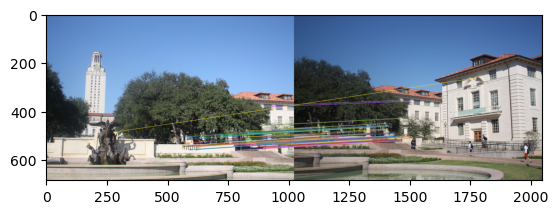

In [80]:
# create a tk window

root= tk.Tk()
root.title('parnaroma img')
root.geometry('600x500')

#create button
select_button= tk.Button(root, text='Select File', command= select_img)
select_button.pack()

root.mainloop()

In [25]:
# https://towardsdatascience.com/image-panorama-stitching-with-opencv-2402bde6b46c